# Draft: MIRI LRS Spectral Extraction (s2d)

***

## Imports
Describe the libraries we're using here. If there's something unusual, explain what the library is, and why we need it.
- *numpy* to handle array functions
- *astropy.io fits* for accessing FITS files
- *astropy.table Table* for creating tidy tables of the data
- *matplotlib.pyplot* for plotting data

In [1]:
# For style checking
# %load_ext pycodestyle_magic
# %flake8_on

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import numpy as np

import astropy.wcs as wcs
from astropy.visualization import simple_norm
from astropy.io import fits
from astropy.table import Table

from jwst import datamodels
from gwcs.wcstools import grid_from_bounding_box

from spextract import get_boxcar_weights, ap_weight_images, extract_1dspec

## Introduction
Extract 1D spectra from 2D MIRI spectral observations.  Show simple "boxcar" extraction as well as a more sophisticated PSF based "optimal" extraction.  PSF based extraction is currently only appropriate for point sources.

Note: Not clear how to use the JWST pipeline `extract_1d` (quite complex) code.

***

## Download File

In [3]:
from astropy.utils.data import download_file
# backup location
calfile = "det_image_seq5_MIRIMAGE_P750Lexp1_cal.fits"
s2dfile = "det_image_seq5_MIRIMAGE_P750Lexp1_s2d.fits"
x1dfile = "det_image_seq5_MIRIMAGE_P750Lexp1_x1d.fits"
# calfile_url = "https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/MIRI_LRS_notebook/det_image_seq5_MIRIMAGE_P750Lexp1_cal.fits"
# calfile = download_file(calfile_url)

## File information

The data used is a simulation of a LRS slit observation of for the star BD+60d1753, a flux calibration star.  This simulation was created with MIRISim.
The simulated exposure was reduced using the JWST pipeline (v0.15.0) through the Detector1 and Spec2 stages.

The cal file is one of the Spec2 products and is the calibration full frame image. It contains:

1. (Primary): This HDU contains meta-data related to the observation and data reduction.
2. (SCI): The calibrated image. Units are MJy/sr.
3. (ERR): Uncertainty image.  Units are MJy/sr.
4. (DQ): Data quality image.
5. (VAR_POISSON): Unc. component 1: Poisson uncertainty image.  Units are (MJy/sr)^2.
6. (VAR_RNOISE): Unc. component 2: Read Noise uncertainty image.  Units are (MJy/sr)^2.
7. (VAR_FLAT): Unc. component 3: Flat Field uncertainty image.  Units are (MJy/sr)^2.
8. (ASDF_METADATA): Metadata.

The s2d file is one of the Spec2 products and containes the calibrated rectified cutout of the LRS Slit region.  It has:

1. (Primary): This HDU contains meta-data related to the observation and data reduction.
2. (WGT): ??
3. (CON): ??
4. (ASDF_METADATA): Metadata.

## Loading data

In [4]:
# use a jwst datamodel to provide a good interface to the data and wcs info
cal = datamodels.open(calfile)
s2d = datamodels.open(s2dfile)
# get the wcs info for the s2d file for later use
grid = grid_from_bounding_box(s2d.meta.wcs.bounding_box)
s2d_ra, s2d_dec, s2d_lam = s2d.meta.wcs(*grid)
print(s2d_lam.max())

14.377025942904403


Basic information about the image.

In [5]:
print("cal image")
print(cal.data.shape)
print(np.mean(cal.data))
print(np.amin(cal.data), np.amax(cal.data))
print("cal image")
print(s2d.data.shape)
print(np.mean(s2d.data))
print(np.amin(s2d.data), np.amax(s2d.data))

cal image
(1024, 1032)
9.826068
-1199.9769 64995.82
cal image
(387, 44)
603.8127
-942.0139 63358.58


Display the full 2D image

Text(0.5, 1.0, 'The full image from the MIRI IMAGER detector')

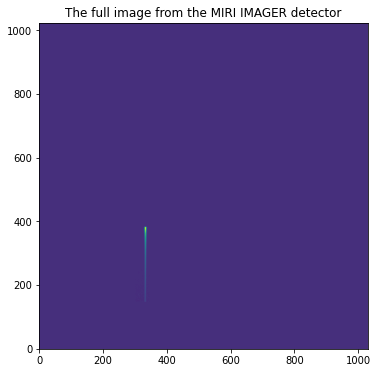

In [6]:
norm_data = simple_norm(cal.data, 'sqrt')
plt.figure(figsize=(6, 6))
plt.imshow(cal.data, norm=norm_data, origin="lower")
plt.title("The full image from the MIRI IMAGER detector")

Display the LRS Slit region only (use s2d)

Text(0.5, 1.0, 'The LRS region')

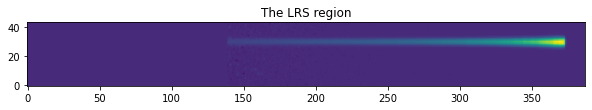

In [7]:
# transpose to make it display better
data_lrs_reg = np.transpose(s2d.data)
norm_data = simple_norm(data_lrs_reg, "sqrt")
plt.figure(figsize=(10, 3))
plt.imshow(data_lrs_reg, norm=norm_data, origin="lower")
plt.title("The LRS region")

JWST pipeline 1D extraction

<TableColumns names=('WAVELENGTH','FLUX','ERROR','SURF_BRIGHT','SB_ERROR','DQ','BACKGROUND','BERROR','NPIXELS')>


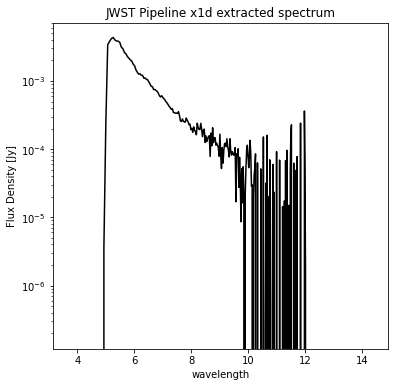

In [8]:
# for reference read in the JWST pipeline extracted spectrum
jpipe_x1d = Table.read(x1dfile, hdu=1)
print(jpipe_x1d.columns)
# plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(jpipe_x1d['WAVELENGTH'], jpipe_x1d['FLUX'], 'k-', label="jpipe_x1d")
ax.set_title("JWST Pipeline x1d extracted spectrum")
ax.set_xlabel("wavelength")
ax.set_ylabel("Flux Density [Jy]")
ax.set_yscale("log")

## Useful Functions

## Boxcar Extraction

Extract a 1D spectrum using a simple boxcar.  Basically collapse the spectrum in the cross-dispersion direction over a specified number of pixels.

Limitation: not clear how to handle bad pixels with boxcar extraction.  Interpolate?

### Fixed width boxcar

Define extraction parameters

In [9]:
ext_center = 30
ext_width = 8
bkg_offset = 4
bkg_width = 2

Plot cross-disperion cut showing the extraction parameters

Text(0.5, 1.0, 'Cross-dispersion Cut at Pixel=300')

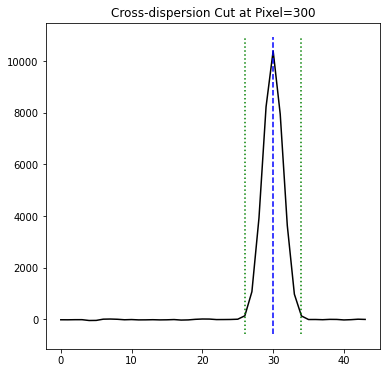

In [10]:
fig, ax = plt.subplots(figsize=(6, 6))
y = np.arange(data_lrs_reg.shape[0])
ax.plot(y, data_lrs_reg[:,300], 'k-')
mm = np.array([ext_center, ext_center])
mm_y = ax.get_ylim()
ax.plot(mm, mm_y, 'b--')
ax.plot(mm - ext_width/2., mm_y, 'g:')
ax.plot(mm + ext_width/2., mm_y, 'g:')
ax.set_title("Cross-dispersion Cut at Pixel=300")

Do the extraction

Text(0.5, 1.0, 'Fixed boxcar backgound weight image')

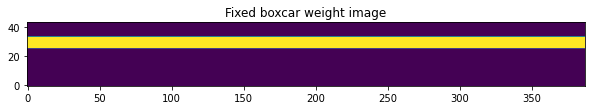

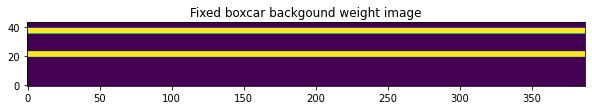

In [11]:
# fixed boxcar weight image
wimage_fixedboxcar, wimage_fb_bkg = ap_weight_images(ext_center, ext_width, bkg_offset, bkg_width, data_lrs_reg.shape, None)

norm_data = simple_norm(wimage_fixedboxcar)
plt.figure(figsize=(10, 3))
plt.imshow(wimage_fixedboxcar, norm=norm_data, origin="lower")
plt.title("Fixed boxcar weight image")

norm_data = simple_norm(wimage_fb_bkg)
plt.figure(figsize=(10, 3))
plt.imshow(wimage_fb_bkg, norm=norm_data, origin="lower")
plt.title("Fixed boxcar backgound weight image")

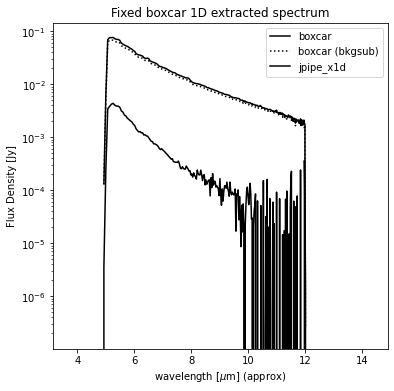

In [12]:
# extract the spectrum using the weight image
waves_boxcar, ext1d_boxcar = extract_1dspec(s2d, ext_center, ext_width, None, None)
waves_boxcar_bkgsub, ext1d_boxcar_bkgsub = extract_1dspec(s2d, ext_center, ext_width, bkg_offset, bkg_width)

# plot
fig, ax = plt.subplots(figsize=(6, 6))
gpts = ext1d_boxcar_bkgsub > 0.
ax.plot(waves_boxcar[gpts], ext1d_boxcar[gpts], 'k-', label="boxcar")
ax.plot(waves_boxcar_bkgsub[gpts], ext1d_boxcar_bkgsub[gpts], 'k:', label="boxcar (bkgsub)")
ax.plot(jpipe_x1d['WAVELENGTH'], jpipe_x1d['FLUX'], 'k-', label="jpipe_x1d")
ax.set_title("Fixed boxcar 1D extracted spectrum")
ax.set_xlabel(r"wavelength [$\mu$m] (approx)")
ax.set_ylabel("Flux Density [Jy]")
ax.set_yscale("log")
ax.legend()

### Wavelength scaled width boxcar

Scaling the width of the extraction aperture with wavelength accounts for the changing diffraction limit with wavelength.

TBD: Trace the peak versus wavelength to allow for a spectral tilt.

Text(0.5, 1.0, 'Scaled boxcar backgound weight image')

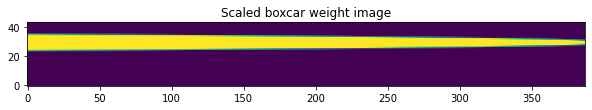

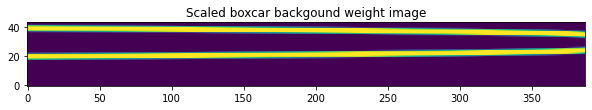

In [13]:
# boxcar scaled with wavelength
wimage_scaledboxcar, wimage_sb_bkg = ap_weight_images(ext_center, ext_width, bkg_offset, bkg_width, data_lrs_reg.shape, waves_boxcar, wavescale=10.0)

norm_data = simple_norm(wimage_scaledboxcar)
plt.figure(figsize=(10, 3))
plt.imshow(wimage_scaledboxcar, norm=norm_data, origin="lower")
plt.title("Scaled boxcar weight image")

norm_data = simple_norm(wimage_sb_bkg)
plt.figure(figsize=(10, 3))
plt.imshow(wimage_sb_bkg, norm=norm_data, origin="lower")
plt.title("Scaled boxcar backgound weight image")

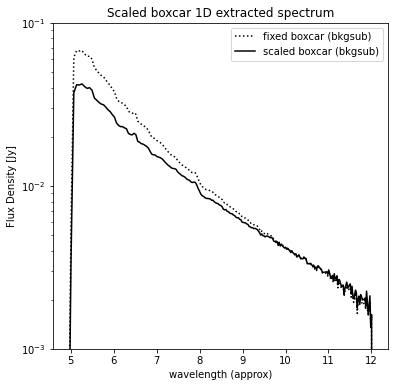

In [14]:
# extract the spectrum using the weight image
waves_sboxcar, ext1d_sboxcar = extract_1dspec(s2d, ext_center, ext_width, None, None, wavescale=10)
waves_sboxcar_bkgsub, ext1d_sboxcar_bkgsub = extract_1dspec(s2d, ext_center, ext_width, bkg_offset, bkg_width, wavescale=10)

# plot
fig, ax = plt.subplots(figsize=(6, 6))
gpts = ext1d_boxcar_bkgsub > 0.
ax.plot(waves_boxcar_bkgsub[gpts], ext1d_boxcar_bkgsub[gpts], 'k:', label="fixed boxcar (bkgsub)")
gpts = ext1d_sboxcar_bkgsub > 0.
ax.plot(waves_sboxcar_bkgsub[gpts], ext1d_sboxcar_bkgsub[gpts], 'k-', label="scaled boxcar (bkgsub)")
ax.set_title("Scaled boxcar 1D extracted spectrum")
ax.set_xlabel("wavelength (approx)")
ax.set_ylabel("Flux Density [Jy]")
ax.set_yscale("log")
ax.set_ylim(1e-3, 1e-1)
ax.legend()


## PSF based Extraction

Use the knowledge of the PSF and how it changes with wavelength to provide an improved extration.

In [15]:
# TBD
# read in a reference file that gives the spatial profile as a function of wavelength (pixel intially)
# fit the spatial profile plus a constant/line for the background for each wavelength
#   fitted scaling factor gives the flux density at that pixel
# use astropy.modeling model sets to fit simultaneously versus wavelength

## Additional Resources
Provide links to appropriate JDox pages for MIRI LRS and JWST pipeline.

- [MIRI LRS](https://jwst-docs.stsci.edu/mid-infrared-instrument/miri-observing-modes/miri-low-resolution-spectroscopy)
- [MIRISim](http://www.stsci.edu/jwst/science-planning/proposal-planning-toolbox/mirisim)
- [JWST pipeline](https://jwst-docs.stsci.edu/jwst-data-reduction-pipeline)
- Include a reference for PSF based extraction (Horne?).

## About this notebook

**Author:** Karl Gordon, JWST
**Updated On:** 2020-05-19

***

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 